In [2]:
import sys
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import ndcube
from sunpy.coordinates import get_earth
import reproject
from sunpy.image.resample import resample
from scipy.io import readsav
from astropy.visualization import ImageNormalize, LogStretch
import sunpy.map

sys.path.append('../scripts')
from util import spectral_cube_wcs, overlappogram_wcs, construct_pcij, color_lat_lon_axes, strided_overlappogram, make_moxsi_ndcube

# More WCS Testing

Trying to fix my WCS problems

In [3]:
norm=ImageNormalize(vmin=0,vmax=1,stretch=LogStretch())
cmap='hinodexrt'
plot_props = {'cmap':cmap, 'norm':norm}

In [4]:
earth = get_earth()

In [5]:
wavelength = np.arange(1,201,1) * u.Angstrom
cube_shape = wavelength.shape + (10, 10)
detector_shape = (100, 20)

In [4]:
spec_cube_wcs = spectral_cube_wcs(cube_shape, wavelength,
                             (10*u.Unit('arcsec/pix'),
                              10*u.Unit('arcsec/pix'),
                              1*u.Unit('angstrom/pix')),
                             earth)
spec_cube = ndcube.NDCube(np.random.rand(*cube_shape), wcs=spec_cube_wcs)

In [5]:
spec_cube.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  
CRVAL : 0.0  0.0  1.005e-08  
CRPIX : 5.5  5.5  100.5  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.002777777777777778  0.002777777777777778  1e-10  
NAXIS : 0  0

<WCSAxesSubplot:>

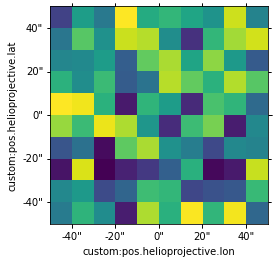

In [21]:
spec_cube[0,...].plot()

In [49]:
pc_matrix = construct_pcij(0*u.deg, 0*u.deg, order=-1)
overlap_wcs = overlappogram_wcs(
    detector_shape,
    wavelength,
    spec_cube.wcs.wcs.cdelt,
    spec_cube.wcs.wcs.cunit,
    pc_matrix,
    earth,
)
overlap_cube = ndcube.NDCube(
    np.random.rand(*(wavelength.shape+detector_shape)),
    wcs=overlap_wcs,
)

(<astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x7ffa1264c430>,
 <astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x7ffa127f0fa0>)

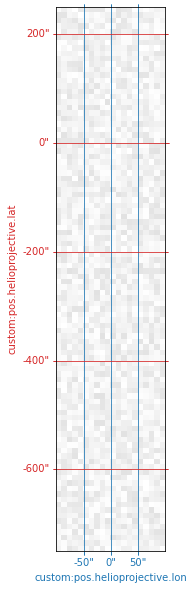

In [10]:
plt.figure(figsize=(3,10))
ax = overlap_cube[25,...].plot(cmap='Greys',vmax=5)
color_lat_lon_axes(ax)

In [50]:
sheared_data = reproject.reproject_interp(
    spec_cube,
    overlap_wcs,
    shape_out=wavelength.shape + detector_shape,
    return_footprint=False,
)
sheared_cube = ndcube.NDCube(sheared_data, wcs=overlap_wcs)

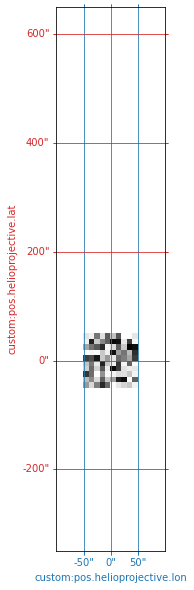

In [53]:
plt.figure(figsize=(3,10))
ax = sheared_cube[15,...].plot(cmap='Greys',vmax=1)
_ = color_lat_lon_axes(ax)

Try this with our actual data (but resampled a bit).

In [6]:
savdata = readsav('../data/forDan_MOXSI_DATA_09112020_0440_feldman.sav')
intensities = savdata['moxsi1_img']
wavelength = savdata['cubixss_wave'] * u.angstrom
wavelength = wavelength[:300]

In [7]:
intensities_resampled = np.stack([resample(i, (20,20), method='linear') for i in intensities])

In [8]:
moxsi_cube = make_moxsi_ndcube(intensities_resampled, wavelength, observer=earth)

<WCSAxesSubplot:>

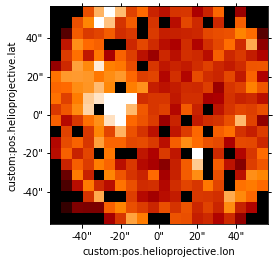

In [95]:
moxsi_cube[327,].plot(**plot_props)

In [9]:
det_shape = (200,40)
overlap_wcs = overlappogram_wcs(
    det_shape,
    wavelength,
    moxsi_cube.wcs.wcs.cdelt,
    moxsi_cube.wcs.wcs.cunit,
    construct_pcij(0*u.deg, 0*u.deg, order=1),
    earth,
)

In [10]:
overlap_wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  
CRVAL : 0.0  0.0  1e-10  
CRPIX : 20.5  100.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  -1.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.0015722222222222223  0.0015722222222222223  5.4816665649414054e-12  
NAXIS : 40  200  300

In [11]:
sheared_moxsi_data = reproject.reproject_interp(
    moxsi_cube,
    overlap_wcs,
    shape_out=wavelength.shape + det_shape,
    return_footprint=False,
)
sheared_moxsi_cube = ndcube.NDCube(sheared_moxsi_data, wcs=overlap_wcs)

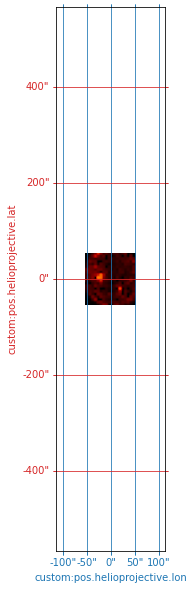

In [12]:
plt.figure(figsize=(3,10))
ax = sheared_moxsi_cube[0,...].plot(**plot_props)
_ = color_lat_lon_axes(ax)

In [15]:
wcs_header = sheared_moxsi_cube.wcs.to_header()

In [20]:
wcs_header['NWAVE'] = sheared_moxsi_cube.data.shape[0]

In [21]:
wcs_header

WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 20.5 / Pixel coordinate of reference point            
CRPIX2  =                100.5 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
PC2_3   =                 -1.0 / Coordinate transformation matrix element       
CDELT1  =   0.0015722222222222 / [deg] Coordinate increment at reference point  
CDELT2  =   0.0015722222222222 / [deg] Coordinate increment at reference point  
CDELT3  =  5.4816665649414E-12 / [m] Coordinate increment at reference point    
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CUNIT3  = 'm'                  / Units of coordinate increment and value        
CTYPE1  = 'HPLN-TAN'           / Coordinate type codegnomonic projection        
CTYPE2  = 'HPLT-TAN'        

In [22]:
import sunpy.io.fits

In [23]:
sunpy.io.fits.write('test-overlap-out.fits', sheared_moxsi_cube.data[0],
                    wcs_header)

In [24]:
import astropy.io.fits

In [26]:
with astropy.io.fits.open('./test-overlap-out.fits') as hdul:
    data = hdul[0].data
    header = hdul[0].header

In [28]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   40                                                  
NAXIS2  =                  200                                                  
WCSAXES =                    3                                                  
CRPIX1  =                 20.5                                                  
CRPIX2  =                100.5                                                  
CRPIX3  =                  1.0                                                  
PC2_3   =                 -1.0                                                  
CDELT1  =   0.0015722222222222                                                  
CDELT2  =   0.0015722222222222                                                  
CDELT3  =  5.4816665649414E-